In [2]:
import os
import youtube_dl
import cv2
import shutil
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel 
import torch

from PIL import Image
import cv2
import os
from tqdm import tqdm
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt

import glob

In [3]:
print('Начался процесс подгрузки модели:')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model_id = 'openai/clip-vit-base-patch32'
model = CLIPModel.from_pretrained(model_id).to(device) 
tokenizer = CLIPTokenizerFast.from_pretrained(model_id) 
processor = CLIPProcessor.from_pretrained(model_id)

Начался процесс подгрузки модели:
cuda:0



---

In [18]:
# Функция для извлечения кадров из видео каждые N секунд
def extract_frames(video_url, interval_sec=10):
    ydl_opts = {}
    ydl = youtube_dl.YoutubeDL(ydl_opts)
    info_dict = ydl.extract_info(video_url, download=False)
    formats = info_dict.get('formats', None)

    # Ищем формат 360p
    desired_format = next((f for f in formats if f.get('format_note') == '360p'), None)

    if desired_format:
        url = desired_format.get('url', None)
        cap = cv2.VideoCapture(url)

        # Получаем общее количество кадров 
        frame_count_max = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        # Устанавливаем частоту кадров видео
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        time_max = frame_count_max * (1/fps) * 1000 # в мс

        # Устанавливаем начальное время итерации
        time_stamp = 0

        # Устанавливаем путь для сохранения кадров
        save_path = 'images'
        frame_count = 0

        while cap.isOpened(): 
            # Устанавливаем позицию видео на текущее время
            cap.set(cv2.CAP_PROP_POS_MSEC, time_stamp)

            # Считываем кадр
            ret, frame = cap.read()

            # выход по превышению времени:
            if time_stamp >= time_max:
                break

            # Если кадр считывается успешно
            if ret:
                # Сохраняем кадр в папку images
                frame_count += 1
                cv2.imwrite(os.path.join(save_path, f"frame_{frame_count}_{video_url.split('=')[-1]}&t={round(time_stamp/1000)}s.jpg"), frame)

                # Увеличиваем время на interval_sec секунд для следующего кадра
                time_stamp += interval_sec * 1000

            else:
                break

        cap.release()
        cv2.destroyAllWindows()

In [19]:
def compute_distances(query_code, image_codes, method='cosine'):
    """
    Вычисляет меру близости между опорным кодом и массивом кодов изображений.

    Параметры:
    - query_code: Опорный код (размером 512).
    - image_codes: Массив кодов изображений (форма: (количество изображений, 512)).
    - method: Метод вычисления близости ('cosine' или 'euclidean').

    Возвращает:
    - Массив близости (форма: (количество изображений)).
    """

    if method == 'cosine':
        # Вычислите косинусное сходство между опорным кодом и всеми кодами изображений
        similarities = cosine_similarity(query_code.reshape(1, -1), image_codes)
        # Преобразуйте в косинусное расстояние (чем меньше, тем лучше)
        distances = 1 - similarities

    elif method == 'euclidean':
        # Вычислите евклидово расстояние между опорным кодом и всеми кодами изображений
        distances = euclidean_distances(query_code.reshape(1, -1), image_codes)
        
    return distances[0]


def display_top_k_images(list_of_files, distances, k=5):
    """
    Отображает top K фотографий с наименьшими расстояниями и выводит список ссылок на видео этих моментов

    Параметры:
    - list_of_files: Список путей к файлам изображений.
    - distances: Массив близости - расстояний (форма: (количество изображений)).
    - k: Количество фотографий для отображения (по умолчанию 5).
    """

    # Получите индексы top K фотографий с наименьшими расстояниями
    top_k_indices = distances.argsort(axis=0)
    #print(top_k_indices)
    image_path_list = []

    # Создайте субграфики для отображения изображений
    num_rows = 1
    num_cols = k
    j = 0 # номер графика
    i = 0 # номер фотки в сортированном списке

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))

    while j<k:
        # Загрузите изображение и отобразите его на соответствующем субграфике
        image_path = list_of_files[top_k_indices[i]]
        
        # Проверяем, является ли изображение дубликатом, проверяя разницу между соседними значениями
        if i > 0 and abs(distances[top_k_indices[i]] - distances[top_k_indices[i - 1]]) < 0.00025:
            i += 1
            continue

        image_path_list.append(image_path)
        image = Image.open(image_path)
        ax = axes[j] if k > 1 else axes

        ax.imshow(image)
        ax.set_title(f'Distance: {distances[top_k_indices[i]]:.3f}')
        ax.axis('off')
        j += 1
        i += 1

    plt.show()

    return ['https://www.youtube.com/watch?v=' + image_path.split('_')[-1][:-4] for image_path in image_path_list]

In [20]:
def make_images_and_embedding(video_urls, seconds_step = 10):
    # Удаляем папку images, если она уже существует
    if os.path.exists('images'):
        shutil.rmtree('images')

    # Создаем папку images
    os.makedirs('images')

    for video_url in video_urls:
        extract_frames(video_url, seconds_step)

    image_folder = 'images'

    # Пустой массив для хранения всех эмбеддингов изображений
    image_embeddings = []
    list_of_files = []

    print('Начался процесс получения эмбеддингов:')

    # Пройдитесь по всем файлам изображений в папке
    for filename in tqdm(os.listdir(image_folder)):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.JPEG') :

            # Загрузите изображение с использованием PIL
            image = Image.open(os.path.join(image_folder, filename))
            list_of_files.append(os.path.join(image_folder, filename))

            # Получите батч изображений и выполните преобразования
            inputs = processor(text=None, images=image, return_tensors="pt", padding=True)
            pixel_values = inputs["pixel_values"].to(device)

            # Получите эмбеддинг изображения
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features.squeeze(0)
            image_features = image_features.cpu().detach().numpy()

            # Добавьте эмбеддинг 
            image_embeddings.append(image_features)


        # Преобразуйте список эмбеддингов в массив NumPy
        image_arr = np.vstack(image_embeddings)

        # Сохраняем массив NumPy в файл
        np.save('image_embeddings.npy', image_arr)

In [21]:
def compute_k_nearest_imaget_to_prompt(text_imput, top_k):
    prompt = "a photo of" + text_imput
    # tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    text_emb = model.get_text_features(**inputs) 
    # Получение латентного кода текстового описания
    query_code = text_emb.squeeze(0).cpu().detach().numpy()


    # Загружаем массив NumPy из файла (в нем латентные коды всех фоток из папки)
    image_arr = np.load('image_embeddings.npy')

    # Получение мер близости
    distances_cosine = compute_distances(query_code, image_arr, method='cosine')


    # Получаем список всех файлов изображений в папке images
    list_of_files = glob.glob('images/*.jpg')
    # Пример использования функции
    list_of_links = display_top_k_images(list_of_files, distances_cosine, k=top_k)
    return list_of_links

___

---

# Запуск кода:

In [24]:
video_urls = ["https://www.youtube.com/watch?v=KoVnzw4nP10", "https://www.youtube.com/watch?v=JkaxUblCGz0", "https://www.youtube.com/watch?v=MhhAox6Zei8", "https://www.youtube.com/watch?v=Uq5o-rpN3Fc"]
seconds_step = 8

make_images_and_embedding(video_urls, seconds_step=seconds_step)

[youtube] KoVnzw4nP10: Downloading webpage
[youtube] MhhAox6Zei8: Downloading webpage
[youtube] Uq5o-rpN3Fc: Downloading webpage
Начался процесс получения эмбеддингов:


100%|██████████| 291/291 [00:07<00:00, 37.24it/s]


---

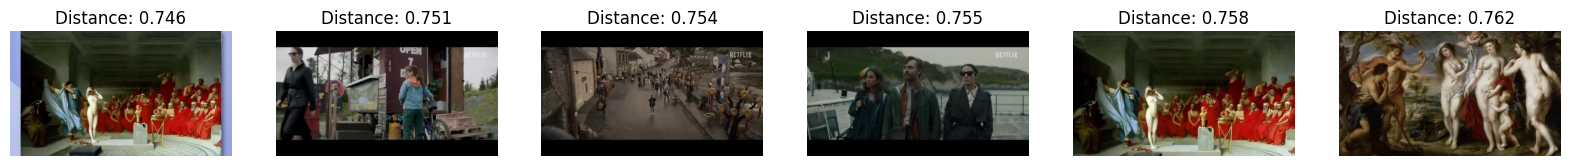

['https://www.youtube.com/watch?v=Uq5o-rpN3Fc&t=280s', 'https://www.youtube.com/watch?v=KoVnzw4nP10&t=40s', 'https://www.youtube.com/watch?v=KoVnzw4nP10&t=32s', 'https://www.youtube.com/watch?v=KoVnzw4nP10&t=16s', 'https://www.youtube.com/watch?v=Uq5o-rpN3Fc&t=288s', 'https://www.youtube.com/watch?v=Uq5o-rpN3Fc&t=376s']


In [25]:
text_imput = 'people surrounding a girl'

list_of_links = compute_k_nearest_imaget_to_prompt(text_imput, top_k=6)
print(list_of_links)

___